In [1]:
!pip install fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.17.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for United States Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	

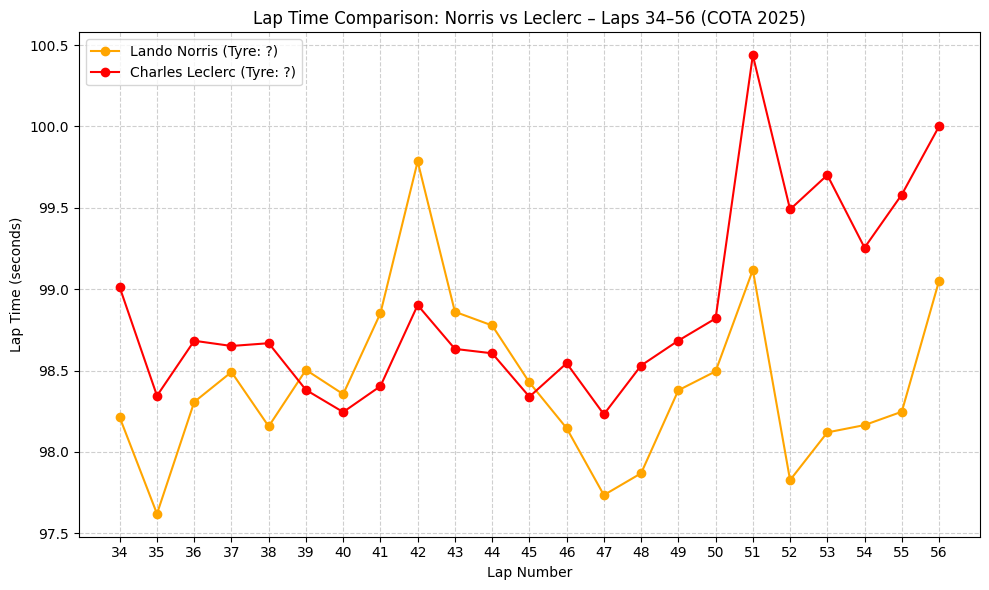

In [3]:
import fastf1
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import os

# Enable Cache

if not os.path.exists('cache'):
  os.makedirs('cache')
fastf1.Cache.enable_cache('cache')


#Load session
session = fastf1.get_session(2025, 'United States Grand Prix', 'R')
session.load()

laps = session.laps

# Filter laps for both drivers (laps 34–56)
lando_laps = laps[(laps['Driver'] == 'NOR') & (laps['LapNumber'] >= 34) & (laps['LapNumber'] <= 56) & laps['LapTime'].notna()].copy()
charles_laps = laps[(laps['Driver'] == 'LEC') & (laps['LapNumber'] >= 34) & (laps['LapNumber'] <= 56) & laps['LapTime'].notna()].copy()

# Drop pit in/out laps safely if columns exist
for name, df in [('Lando', lando_laps), ('Charles', charles_laps)]:
    if 'PitOutLap' in df.columns:
        df = df[~df['PitOutLap']]
    if 'PitInLap' in df.columns:
        df = df[~df['PitInLap']]
    if name == 'Lando':
        lando_laps = df
    else:
        charles_laps = df

# Convert LapTime to seconds
lando_laps.loc[:, 'LapTime_s'] = lando_laps['LapTime'].dt.total_seconds()
charles_laps.loc[:, 'LapTime_s'] = charles_laps['LapTime'].dt.total_seconds()

# Filter unrealistic or VSC-affected laps (>105 sec)
lando_laps = lando_laps[lando_laps['LapTime_s'] <= 105]
charles_laps = charles_laps[charles_laps['LapTime_s'] <= 105]

# Keep only quick laps
lando_laps = lando_laps.pick_quicklaps()
charles_laps = charles_laps.pick_quicklaps()

# Plot
plt.figure(figsize=(10,6))
plt.plot(lando_laps['LapNumber'], lando_laps['LapTime_s'], 'o-', color='orange', label='Lando Norris (Tyre: ?)')  # update tyre
plt.plot(charles_laps['LapNumber'], charles_laps['LapTime_s'], 'o-', color='red', label='Charles Leclerc (Tyre: ?)')

plt.xlabel('Lap Number')
plt.ylabel('Lap Time (seconds)')
plt.title('Lap Time Comparison: Norris vs Leclerc – Laps 34–56 (COTA 2025)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xticks(range(34, 57))
plt.show()
